In [19]:
NUMBER_OF_EPOCH = 50000
# num_of_categories = 

In [20]:
import torch
import torch.nn as nn
import pandas as pd
import preprossesing as pre
import math
if torch.backends.mps.is_available():
    mps_device = torch.device("mps")
    x = torch.ones(1, device=mps_device)
    print (x)
else:
    print ("MPS device not found.")
    

tensor([1.], device='mps:0')


In [21]:
def prepare_model(df):
    
    df = pre.standardize(df)
    df = pre.encoder(df)
    df = df.drop(['id'], axis=1)

    train, val = pre.test_validation_split(df)
    
    y_train = torch.tensor(train['price'].values, dtype=torch.float32)
    X_train = train.drop(['price'], axis=1)
    X_train = torch.tensor(X_train.values, dtype=torch.float32)
    
    y_val = torch.tensor(val['price'].values, dtype=torch.float32)
    X_val = val.drop(['price'], axis=1)
    X_val = torch.tensor(X_val.values, dtype=torch.float32)
    
    return X_train, y_train, X_val, y_val

In [22]:
# Define model
class mlp(nn.Module):
    def __init__(self):
        super(mlp, self).__init__()
        
        self.layers = nn.Sequential(
        nn.Linear(8, 256),
        nn.ReLU(), 
        
        nn.Linear(256, 256),
        nn.Dropout(0.1),
        nn.ReLU(), 
        
        nn.Linear(256, 64),
        nn.ReLU(), 
        
        nn.Linear(64, 32),
        nn.ReLU(), 
        
        nn.Linear(32, 1) 
        )
        
        self.model_layer = nn.Sequential(
        nn.Linear(151, 1),
        nn.ReLU()
        )
        
        self.gear_box_layer = nn.Sequential(
        nn.Linear(3, 1),
        nn.ReLU()
        )
        
        self.fuel_type_layer = nn.Sequential( 
        nn.Linear(4, 1),
        nn.ReLU()
        )
        
        self.registration_fee_layer = nn.Sequential(
        nn.Linear(8, 1),
        nn.ReLU()
        )
        
        self.engine_capacity_layer = nn.Sequential(
        nn.Linear(10, 1),
        nn.ReLU()
        )
    
        
    def forward(self, x):
        model = self.model_layer(x[:, :151])
        gear_box = self.gear_box_layer(x[:, 151:154])
        fuel_type = self.fuel_type_layer(x[:, 154:158])
        registration_fee = self.registration_fee_layer(x[:, 158:166])
        engine_capacity = self.engine_capacity_layer(x[:, 166:176])
        operating_hours = x[:, 176].view(-1, 1)
        year = x[:, 177].view(-1, 1)
        efficiency = x[:, 178].view(-1, 1)

        
        x = torch.cat((model, year, gear_box, operating_hours, fuel_type, registration_fee, efficiency, engine_capacity), 1)
        
        return self.layers(x)

model = mlp()
model

mlp(
  (layers): Sequential(
    (0): Linear(in_features=8, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=256, bias=True)
    (3): Dropout(p=0.1, inplace=False)
    (4): ReLU()
    (5): Linear(in_features=256, out_features=64, bias=True)
    (6): ReLU()
    (7): Linear(in_features=64, out_features=32, bias=True)
    (8): ReLU()
    (9): Linear(in_features=32, out_features=1, bias=True)
  )
  (model_layer): Sequential(
    (0): Linear(in_features=151, out_features=1, bias=True)
    (1): ReLU()
  )
  (gear_box_layer): Sequential(
    (0): Linear(in_features=3, out_features=1, bias=True)
    (1): ReLU()
  )
  (fuel_type_layer): Sequential(
    (0): Linear(in_features=4, out_features=1, bias=True)
    (1): ReLU()
  )
  (registration_fee_layer): Sequential(
    (0): Linear(in_features=8, out_features=1, bias=True)
    (1): ReLU()
  )
  (engine_capacity_layer): Sequential(
    (0): Linear(in_features=10, out_features=1, bias=True)
    (1): ReLU()


In [23]:
class RMSELoss(nn.Module):
    def __init__(self):
        super(RMSELoss, self).__init__()
        self.mse = nn.MSELoss()

    def forward(self, y_pred, y_true):
        return torch.sqrt(self.mse(y_pred, y_true))

In [24]:
loss_fn = RMSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [25]:
df = pd.read_csv('data/train.csv')
X_train, y_train, X_val, y_val = prepare_model(df)
print(X_train.shape, y_train.shape, X_val.shape, y_val.shape)

torch.Size([8550, 179]) torch.Size([8550]) torch.Size([950, 179]) torch.Size([950])


In [26]:
import numpy as np
best_val_loss = float('inf')
training_loss = np.array([])
validation_loss = np.array([])
last_val_loss = float('inf')
count = 0

for n in range(NUMBER_OF_EPOCH):
    model.train()
    y_pred = model(X_train)[:, 0]
    loss = loss_fn(y_pred, y_train)
    training_loss = np.append(training_loss, loss.item())
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    model.eval()
    y_pred = model(X_val)[:, 0]
    val_loss = loss_fn(y_pred, y_val)
    validation_loss = np.append(validation_loss, val_loss.item())
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model, 'mlp_model.pth')
    
    if n % 100 == 0:
        print(f'Epoch: {n} Loss: {loss.item()}'f' Validation loss: {val_loss.item()}'f' best Validation loss: {best_val_loss}')
        
    if last_val_loss < val_loss:
        count += 1
        if count == 25:
            break
    else:
        count = 0
    last_val_loss = val_loss
    

Epoch: 0 Loss: 18322.19921875 Validation loss: 18768.974609375 best Validation loss: 18768.974609375
Epoch: 100 Loss: 15473.501953125 Validation loss: 15755.728515625 best Validation loss: 15755.728515625
Epoch: 200 Loss: 7076.4091796875 Validation loss: 7255.91748046875 best Validation loss: 7255.91748046875
Epoch: 300 Loss: 6334.11669921875 Validation loss: 6393.8564453125 best Validation loss: 6393.8564453125
Epoch: 400 Loss: 5405.54736328125 Validation loss: 5404.375 best Validation loss: 5404.375
Epoch: 500 Loss: 2958.21826171875 Validation loss: 3038.48193359375 best Validation loss: 3038.48193359375
Epoch: 600 Loss: 2577.322021484375 Validation loss: 2698.880859375 best Validation loss: 2698.880859375
Epoch: 700 Loss: 2433.5859375 Validation loss: 2555.923828125 best Validation loss: 2555.923828125
Epoch: 800 Loss: 2352.380615234375 Validation loss: 2478.0126953125 best Validation loss: 2478.0126953125
Epoch: 900 Loss: 2302.010986328125 Validation loss: 2437.137451171875 best Va

KeyboardInterrupt: 

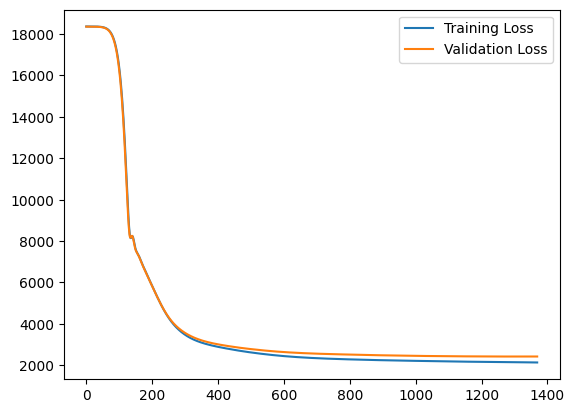

In [ ]:
import matplotlib.pyplot as plt

plt.plot(training_loss, label='Training Loss')
plt.plot(validation_loss, label='Validation Loss')
plt.legend(loc='best')

In [ ]:
import pickle

df = pd.read_csv('data/test.csv')
model = torch.load('mlp_model.pth')
model.eval()

index = df['id']
df = df.drop(['id'], axis=1)
X = pre.encoder(df)
X = pre.standardize(X, scaler=pickle.load(open('scaler.pkl', 'rb')))
X = torch.tensor(X.values, dtype=torch.float32)
y_pred = model(X)[:, 0]

df = pd.DataFrame(y_pred.detach().numpy(), columns=['price'])
df = pd.concat([index, df], axis=1)
df.rename(columns={'price': 'answer'}, inplace=True)
df.to_csv('output.csv', index=False)

/var/folders/64/cy9kvd894_bfkfb71dsbxt2w0000gn/T/ipykernel_90506/228361571.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load('mlp_model.pth')
